<a href="https://colab.research.google.com/github/mb1h0101/MB1H0101/blob/main/LSTM_%E9%A0%90%E6%B8%AC%E5%A0%B1%E5%91%8A%E8%88%87%E9%97%9C%E8%81%AF%E5%88%86%E6%9E%90_v3_%E5%84%AA%E5%8C%96%E6%A8%A1%E5%9E%8B%E8%88%87%E7%95%B0%E5%B8%B8%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 環境感測資料分析：LSTM 預測模型（pH、DO、水溫、ORP、導電度）

In [ ]:
# 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## 📁 載入資料與清理

In [ ]:
# 讀取檔案，使用 Big5 編碼
df = pd.read_csv('env_data.csv', encoding='big5')

# 去除欄位空白字元
df.columns = df.columns.str.strip()

# 篩選使用欄位
target_cols = ['IM13570 - pH', 'IM13570 - DO飽和度', 'IM13570 - 水溫', 'IM13570 - ORP', 'IM13570 - SC']
df = df[target_cols]

# 清除極端值
df = df[(df['IM13570 - pH'] >= 5) & (df['IM13570 - pH'] <= 9)]
df = df[(df['IM13570 - DO飽和度'] >= 0) & (df['IM13570 - DO飽和度'] <= 200)]
df = df[(df['IM13570 - ORP'] >= -1000) & (df['IM13570 - ORP'] <= 1000)]
df = df[(df['IM13570 - 水溫'] >= 0) & (df['IM13570 - 水溫'] <= 50)]
df = df[(df['IM13570 - SC'] >= 0)]

# 補缺值
df = df.fillna(df.mean(numeric_only=True))
df.describe()

,IM13570 - pH,IM13570 - DO飽和度,IM13570 - 水溫,IM13570 - ORP,IM13570 - SC
count,697.000000,697.000000,697.000000,697.000000,697.000000
mean,7.100646,29.464562,21.532138,262.368580,10.462984
std,0.213696,23.562211,3.653769,186.460569,4.922463
min,5.830000,0.000000,13.400000,-432.500000,0.100000
25%,6.960000,6.700000,18.800000,268.300000,7.300000
50%,7.070000,27.400000,20.800000,312.300000,8.900000
75%,7.220000,43.800000,24.800000,343.600000,11.700000
max,7.710000,109.100000,41.000000,417.600000,21.600000


## 🧪 LSTM 預測模型訓練

In [ ]:
# 時序樣本切分函數
def create_sequence(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# 資料標準化
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# 時序建構與切分
X, y = create_sequence(scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [ ]:
# 建立模型
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(32, activation='relu'),
    Dense(y.shape[1])
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32,
          validation_split=0.2, callbacks=[EarlyStopping(patience=5)], verbose=1)

# 預測並反標準化
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2174 - val_loss: 0.0881
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0503 - val_loss: 0.0240
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0183 - val_loss: 0.0144
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0185
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0121 - val_loss: 0.0184
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0096 - val_loss: 0.0177
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0168
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077 - val_loss: 0.0171
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


## 📈 各變數預測圖（True vs Predicted）

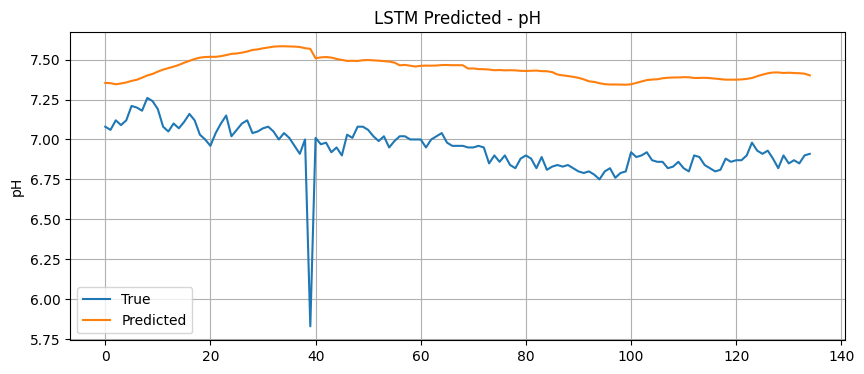

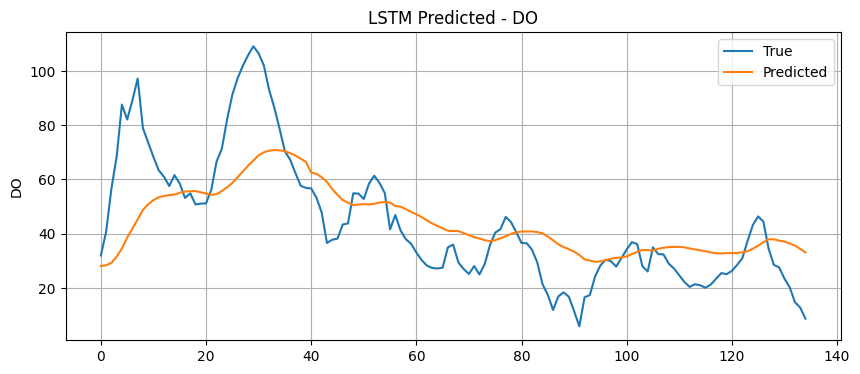

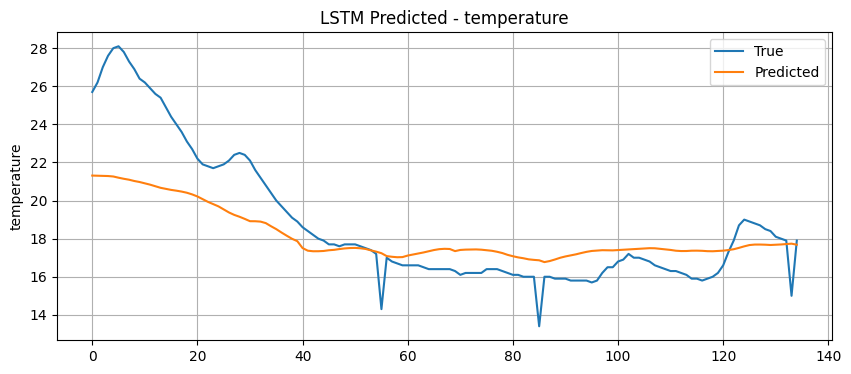

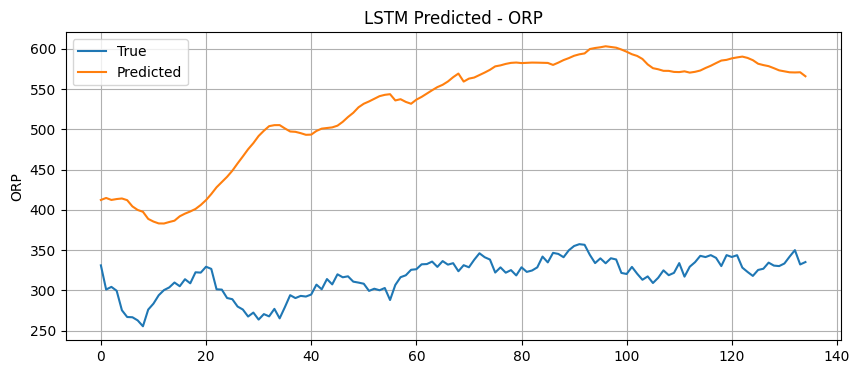

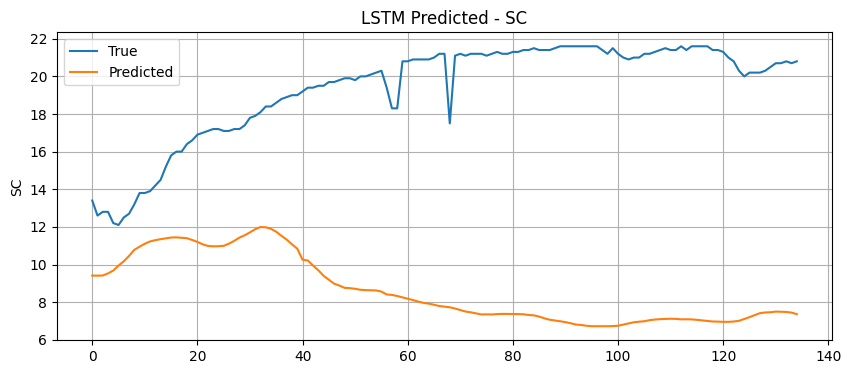

In [ ]:
labels = ['pH', 'DO', 'temperature', 'ORP', 'SC']
for i in range(len(labels)):
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv[:, i], label='True')
    plt.plot(y_pred_inv[:, i], label='Predicted')
    plt.title(f'LSTM Predicted - {labels[i]}')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)
    plt.show()

## 🧾 模型預測誤差報告

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

labels = ['pH', 'DO', '水溫', 'ORP', 'SC']
for i in range(len(labels)):
    mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    print(f'{labels[i]} 預測誤差：')
    print(f'  RMSE = {rmse:.3f}')
    print(f'  MAE  = {mae:.3f}')
    print('---')

pH 預測誤差：
  RMSE = 0.519
  MAE  = 0.497
---
DO 預測誤差：
  RMSE = 16.931
  MAE  = 12.692
---
水溫 預測誤差：
  RMSE = 2.332
  MAE  = 1.689
---
ORP 預測誤差：
  RMSE = 218.022
  MAE  = 210.924
---
SC 預測誤差：
  RMSE = 11.509
  MAE  = 10.749
---


## 📌 五變數間關聯分析（原始資料）

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 28331 (\N{CJK UNIFIED IDEOGRAPH-6EAB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missi

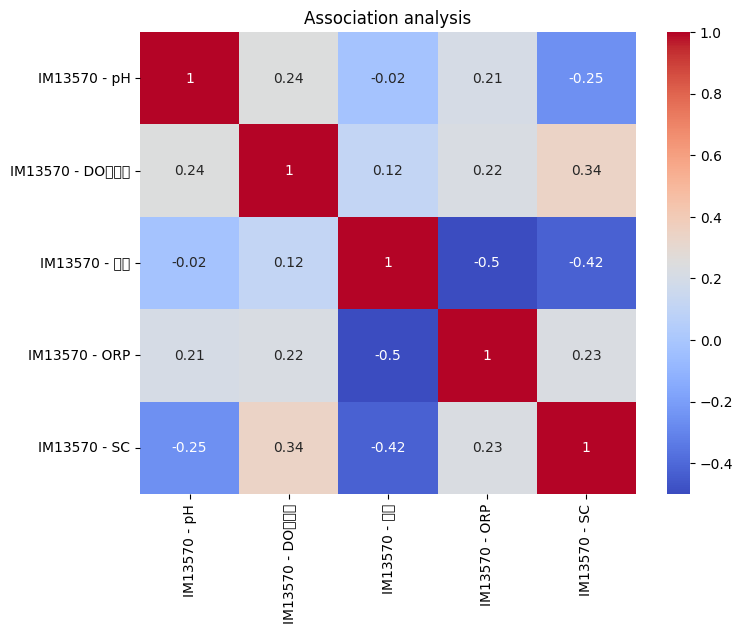

In [ ]:
# 熱圖
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Association analysis')
plt.show()

In [ ]:
# 各變數與其他欄位的關聯性排序
for col in df.columns:
    print(f'🔍 {col} 與其他變數的關聯排序：')
    print(df.corr(numeric_only=True)[col].drop(col).sort_values(ascending=False))
    print('---\n')

🔍 IM13570 - pH 與其他變數的關聯排序：
IM13570 - DO飽和度    0.244334
IM13570 - ORP      0.207431
IM13570 - 水溫      -0.019696
IM13570 - SC      -0.254026
Name: IM13570 - pH, dtype: float64
---

🔍 IM13570 - DO飽和度 與其他變數的關聯排序：
IM13570 - SC     0.343368
IM13570 - pH     0.244334
IM13570 - ORP    0.221671
IM13570 - 水溫     0.115029
Name: IM13570 - DO飽和度, dtype: float64
---

🔍 IM13570 - 水溫 與其他變數的關聯排序：
IM13570 - DO飽和度    0.115029
IM13570 - pH      -0.019696
IM13570 - SC      -0.424494
IM13570 - ORP     -0.499889
Name: IM13570 - 水溫, dtype: float64
---

🔍 IM13570 - ORP 與其他變數的關聯排序：
IM13570 - SC       0.231549
IM13570 - DO飽和度    0.221671
IM13570 - pH       0.207431
IM13570 - 水溫      -0.499889
Name: IM13570 - ORP, dtype: float64
---

🔍 IM13570 - SC 與其他變數的關聯排序：
IM13570 - DO飽和度    0.343368
IM13570 - ORP      0.231549
IM13570 - pH      -0.254026
IM13570 - 水溫      -0.424494
Name: IM13570 - SC, dtype: float64
---



## 優化版 LSTM 模型 + Autoencoder 異常分析 + 結果匯出

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0354 - val_loss: 0.0032
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - val_l

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


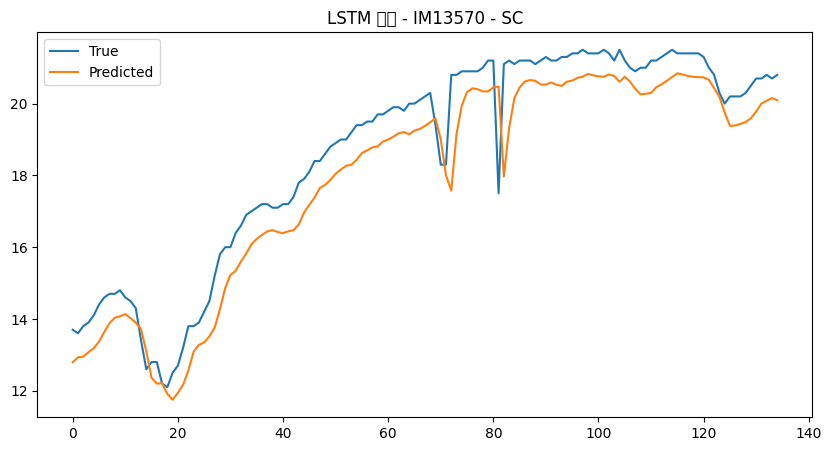

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ===== 資料準備與欄位清理 =====
df.columns = df.columns.str.strip()  # 去除欄位名空白
target_col = 'IM13570 - SC'          # 可修改成其他目標變數

# 清除 NA 與極端值
df = df.dropna()
df = df[df[target_col] < df[target_col].quantile(0.99)]  # 移除極端值

# 製作時間序列資料（例如過去12小時預測未來1小時）
def create_dataset(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# 正規化
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(df[[target_col]])

X, y = create_dataset(scaled_series, time_steps=12)

# 分割訓練測試集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===== 建立 LSTM 模型 =====
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
          callbacks=[EarlyStopping(patience=5)], verbose=1)

# ===== 預測與還原 =====
predicted = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
pred_inv = scaler.inverse_transform(predicted)

# ===== 畫圖比較 =====
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='True')
plt.plot(pred_inv, label='Predicted')
plt.title('LSTM 預測 - ' + target_col)
plt.legend()
plt.show()

# ===== 匯出預測結果 =====
df_result = pd.DataFrame({
    'True': y_test_inv.flatten(),
    'Predicted': pred_inv.flatten()
})
df_result.to_csv("LSTM_預測結果.csv", index=False, encoding="utf-8-sig")


In [ ]:
# ===== Autoencoder 用於異常分析 =====

# 使用所有數值欄位進行 Autoencoder
numerical_df = df.select_dtypes(include=[np.number])
scaler_ae = MinMaxScaler()
scaled_data = scaler_ae.fit_transform(numerical_df)

# 建立 Autoencoder
input_dim = scaled_data.shape[1]
encoding_dim = 4
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 訓練模型
autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32, shuffle=True, verbose=1)

# 異常分析
reconstructions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# 加入結果欄位
df["重建誤差"] = mse
df["是否異常"] = anomalies

# 匯出異常分析結果
df.to_csv("預測與異常分析結果.csv", index=False, encoding="utf-8-sig")


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0969
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0900 
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0818  
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0760 
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0738 
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0691 
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658 
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0663 
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640 
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0624 
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0589 
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0576 
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0563 
Epoch

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
